In [1]:
from salience.LRP.LRP_visu import LRP_vis
import salience.Cam_Functions as cf
import training.Loader as Loader
from PIL import Image
import cv2
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
cuda = True


In [2]:
dataset_path = 'YOUR DATA-SET PATH'
#reload Net
from evaluation import utils
args, model = utils.reload('../output/','vit3',dataset_path,reload=True)

##ugly stuff##
args.batch_size = 1

model.eval()
_,transforms = Loader.getArgmentation(args)
name = args.exp_name

    
s = torch.nn.Sigmoid()

relaod settings C:/Users/rober/Desktop/ios/output/02_prelimi/Vit3_cl5
reload C:/Users/rober/Desktop/ios/output/02_prelimi/Vit3_cl5\commandline_argsJan-27.txt


Using cache found in C:\Users\rober/.cache\torch\hub\facebookresearch_deit_main


reload last Checkpoint for  deit_16_224_base


In [3]:
"Pneumothorax"
import dataloader.siim_acr_pneumothorax_segmentation as ssim
ssim_ds = ssim.SIIMDatasetSingle(root=dataset_path,cache_dir = None)

In [4]:
def getSample(index):
    x = ssim_ds.getSample(index)
    input_tensor = transforms(x[0])
    if cuda:
        input_tensor = input_tensor.cuda()
    org_input = np.array(x[0])
    seg = np.array(x[2])
    gt = x[3]
    if len(input_tensor.shape) == 3:
        input_tensor = torch.unsqueeze(input_tensor, 0)
    return input_tensor,org_input,seg,gt


In [5]:
import evaluation.roc as roc
args.hint1 = 1
args.hint2 = 0
roc_path, selected_index = roc.get_roc_name(args, model)
x = np.load(roc_path)
print(x[1].argmax())
input_tensor,org_input,seg,gt = getSample(x[1].argmax())
negative_example,_,_,gt2 = getSample(x[1].argmin())

idx_tp = np.where(np.logical_and(x[0] == 1, x[1] >= 0.8))[0]
out = s(model(input_tensor))
print((out),gt*100)
out = s(model(negative_example))
print((out),gt2*100)

16
tensor([[1.0000e+00, 2.6472e-12, 1.2324e-13, 3.5281e-11, 2.2839e-10]],
       device='cuda:0', grad_fn=<SigmoidBackward>) 0
tensor([[5.5674e-22, 5.7858e-14, 2.0183e-11, 9.9256e-01, 5.3707e-13]],
       device='cuda:0', grad_fn=<SigmoidBackward>) 0


6 0.9999996423721313
196/196 -- tensor([1.7435e-19]); Min:False; Methode:GradCAM     
14 0.9998916387557983
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
18 0.9999985694885254
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
28 0.9999780654907227
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
29 0.9999556541442871
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
36 0.9999966621398926
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
38 0.8752282857894897
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
41 1.0
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
46 0.999998927116394
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
50 0.9847159385681152
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
51 0.9999998807907104
196/196 -- tensor([5.5674e-22]); Min:False; Methode:GradCAM     
54 0.9951319694519043
196/196 -- tensor([5.5674e-22]); Min:F

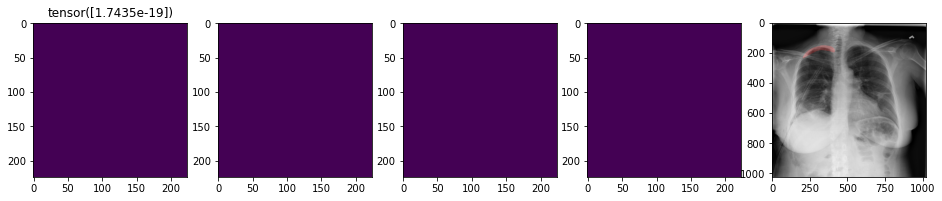

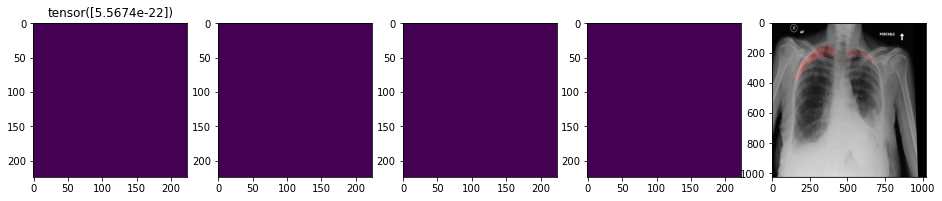

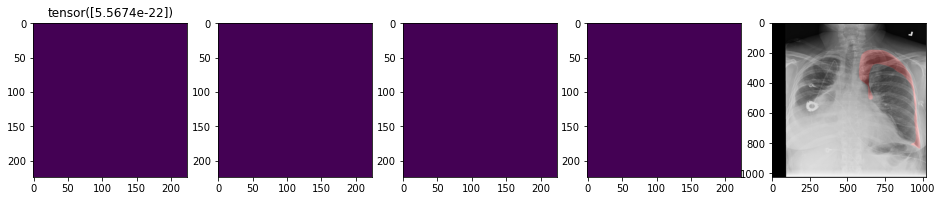

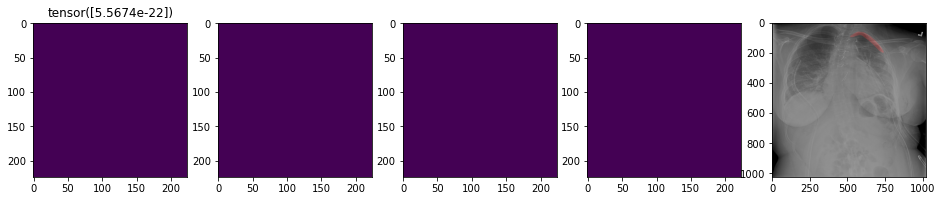

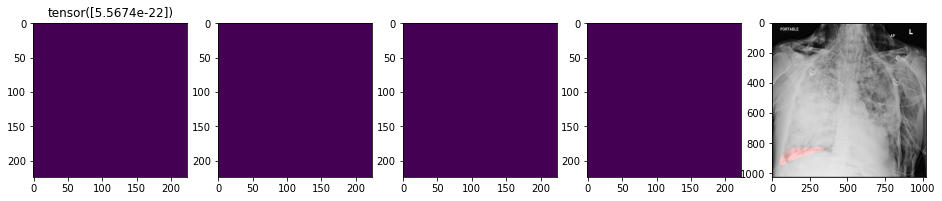

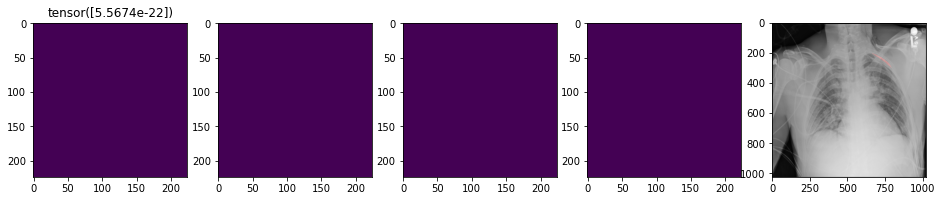

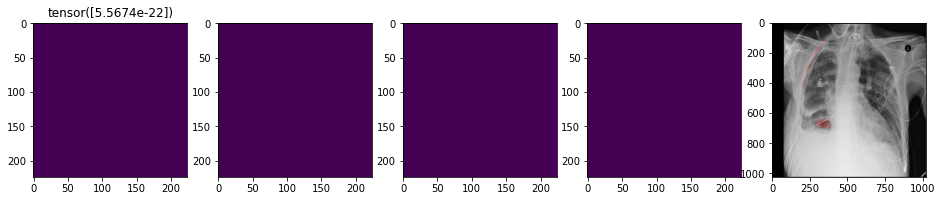

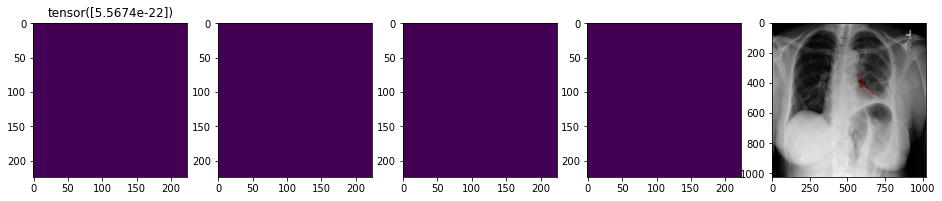

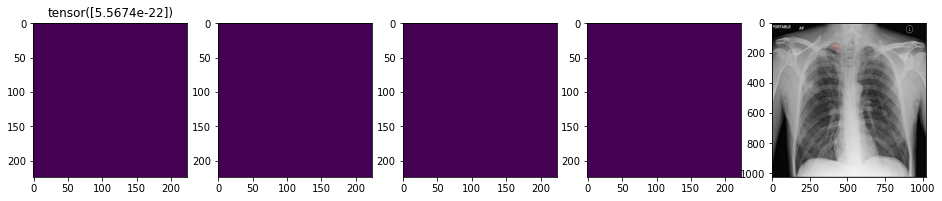

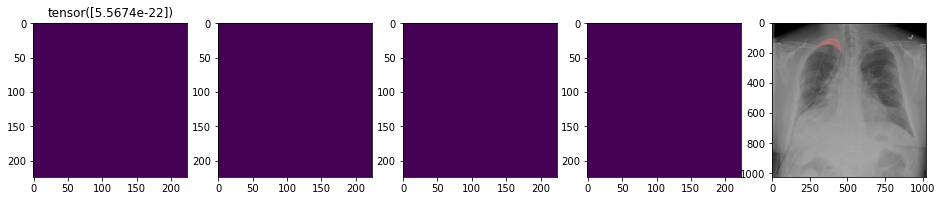

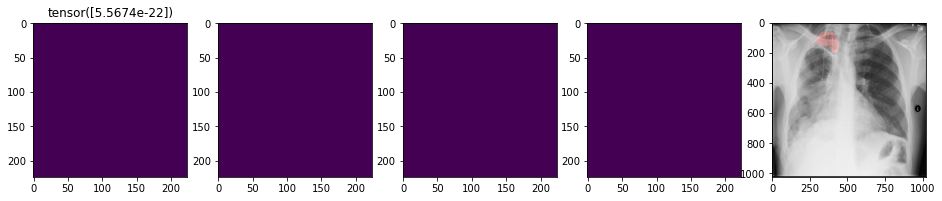

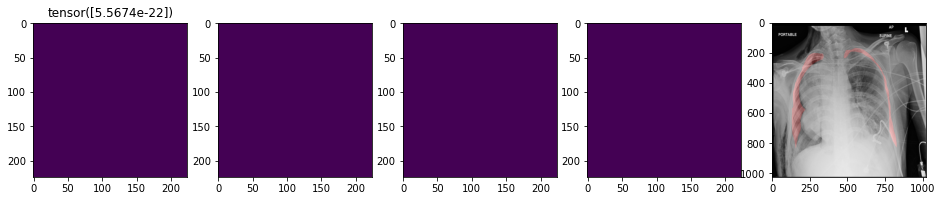

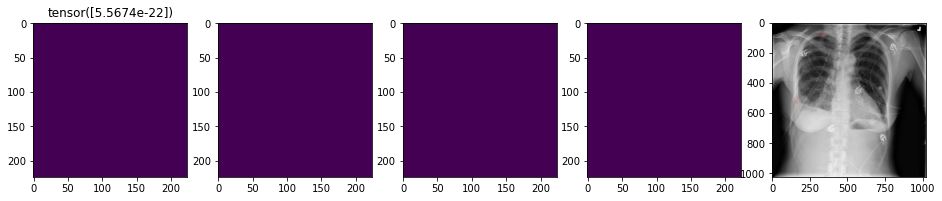

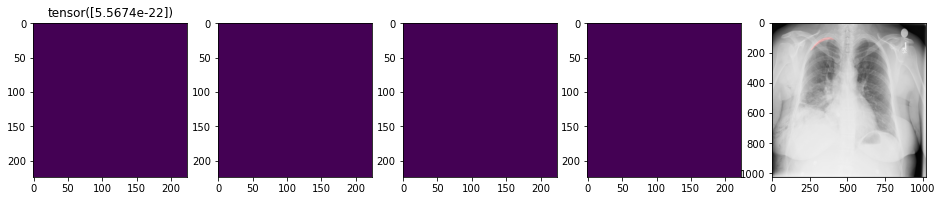

In [8]:
#pertubation_step(camCol: CamCollection, name: str, input_tensor, filtermask, show=False, min_value=False, mode=0, negative_example=None)
#compute_pertubation_curve(camCol: CamCollection, name, input_tensor, min_value, mode, negative_example=None)
from salience.Cam_Collection import CamCollection
from evaluation.perturbation import pertubation_step
camCol = CamCollection(model, name, args, class_index=0)
names = camCol.id2cam
typs = ['min_', 'max_']
dic_curve = {}
dic_auc = {}
j = 1 #GradCam = 1
i = 1 #min = 0; max = 1
current_name = typs[i] + names[j]
min_value=(i == 0)
mode=j
num_patches = 196
curve = np.zeros((num_patches,))
filtermask = input_tensor.clone()*0+1
out = 1
for idx in idx_tp:
    print(idx, x[1][idx])
    input_tensor,org_input,seg,gt = getSample(idx)
    for i in range(num_patches):
        
        # filtermask[i:i+1,i:i+1]*=0
        filtermask, out = pertubation_step(camCol, name, input_tensor, filtermask,
                                            show=False, min_value=min_value, mode=mode, negative_example=negative_example)
        if out is None:
            print('break')
            break
        curve[i] = out
        sys.stdout.write(f"\r{i+1}/{num_patches} -- {out}; Min:{min_value}; Methode:{camCol.id2cam[mode]}     ") 
        if i == 195:
            #visu = cf.show_cam_on_image2(org_input,cam)
            fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols = 5, figsize=(16, 16))
            ax1.set_title(f"{out}")
            _ = ax1.imshow(filtermask.data.cpu().numpy()[0,0])
            _ = ax2.imshow(filtermask.data.cpu().numpy()[0,0])
            _ = ax3.imshow(filtermask.data.cpu().numpy()[0,0])
            _ = ax4.imshow(filtermask.data.cpu().numpy()[0,0])
            _ = ax5.imshow(seg)
    print()
    #break
    if idx >= 100:
        break


In [14]:
#from timm.data.constants import IMAGENET_DEFAULT_MEAN

def sigmoid_array(x):                                        
    return 1 / (1 + np.exp(-x))
def norm(i):
    return (i-i.min())/(i.max()-i.min())


import torch.optim as optim
def remove_max_att(model,input_tensor,filtermask, show=False, min_value=False,mode = 0):
    with torch.no_grad():
        input_tensor = input_tensor.detach()
        fit = input_tensor*filtermask
        fit += negative_example* (1-filtermask)
        #fit[filtermask==0] = input_tensor.max()
        fit = fit.detach()
    if mode == 0:
        cam,org_cam,out = cf.generate_visualization_tmme(model,fit,class_index=0)
    elif mode == 1:
        cam,org_cam,out = LRP_vis(name,model,fit)
    elif mode == 2:
        cam,org_cam,out = cf.generate_visualization_GradCAM(name,model,fit,class_index=0,vit=True,cuda=cuda)
        
    else:
        raise NotImplementedError
    #print(cam.shape,org_cam.shape,out.shape)
    filtermask_small = filtermask[...,1,::16,::16].detach().cpu().numpy()
    org_cam*=filtermask_small
    if min_value:
        org_cam[0][filtermask_small==0] = 2
    
    with torch.no_grad(): 
        if min_value:
            idx = org_cam.argmin()
            org_cam[0][filtermask_small==0] = 0
        else:
            idx = org_cam.argmax()
        x = idx // model.num_patch*16
        y = idx % model.num_patch*16
        filtermask[...,x:x+16,y:y+16]*=0
        fit[:,0][filtermask[:,0]==0]=input_tensor.max()
        if show:
            visu = cf.show_cam_on_image2(org_input,cam)
            fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols = 5, figsize=(16, 16))
            ax1.set_title(f"{int(sigmoid_array(out).item()*10000)/100}")
            ax2.set_title(f"{int(org_cam.max().item()*10000)/100}")
            ax3.set_title(f"{x/16},{y/16}")
            ax4.set_title(f"{fit.max()},{fit.min()}")
            _ = ax1.imshow(org_cam[0,0])
            _ = ax2.imshow(visu)
            _ = ax3.imshow(filtermask.data.cpu().numpy()[0,0])
            _ = ax4.imshow((norm(fit)).cpu()[0].permute(1,2,0).numpy())#filtermask*input_tensor
            _ = ax5.imshow(seg)
            
        del fit
        del model.last_att
        model.last_att = []
        torch.cuda.empty_cache()
        return filtermask.detach().clone(),sigmoid_array(out).item()
filtermask = input_tensor.clone()*0+1
show = False
do_break =False
out = 1
for i in range(model.num_patch*model.num_patch):#model.num_patch*model.num_patch
    #filtermask[i:i+1,i:i+1]*=0
    out_old = out
    filtermask,out = remove_max_att(model,input_tensor,filtermask,show = show,min_value=False,mode=0)
    if do_break:
        break
    if out_old>0.99 and out < 0.99:
        #print(i)
        show = True
    elif out_old>0.5 and out < 0.5:
        #print(i)
        show = True
    elif out_old>0.05 and out < 0.05:
        show = True
        #print(i)
        show = True
    elif out_old>0.001 and out < 0.001:
        #print(i)
        show = True
        #do_break = True
    elif i%50 == 49:
        show = True
    elif i == model.num_patch*model.num_patch-2:
        show = True
    else:
        show = False
    
    t = torch.cuda.get_device_properties(0).total_memory/2
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved
    print(i,int(out*10000)/100,'\t','\t','\t',filtermask.sum().item()/768,int(r/t*100),int(100*a/t),int(100*f/t))

#print(idx//model.num_patch,idx%model.num_patch,org_cam.reshape((-1))[idx],visualization3.shape)


AttributeError: 'Attention' object has no attribute 'attention_map'

In [ ]:
import evaluation.perturbation as pert
#dic_curve,dic_auc = pert.compute_pertubation_curve_all(model,name,input_tensor,)
pert.ssim_ds = ssim_ds
x = np.load("../output/Net2020/Vit3_on_class2/ssim_prep.npy")
#x = np.array([[0,1,1],[0.2,.8,.9]])
#idx = [i for i in range(x.shape[1])]
#np.stack((x,np.array(idx)))
cutoff = 0.5
ssim_ds.data.df["Prediction"] = x[1].round(decimals=5)*100

idx_tp = np.where(np.logical_and(x[0] == 1,x[1] >=cutoff))[0]
idx_fp = np.where(np.logical_and(x[0] == 0,x[1] >=cutoff))[0]

buffer_tp = pert.compute_pertubation_curve_by_index_list(idx_tp[:2],model,name,transforms,negative_example=negative_example)
buffer_fp = pert.compute_pertubation_curve_by_index_list(idx_fp[:1],model,name,transforms,negative_example=negative_example)

In [ ]:

#dic_curve
#legend = []
#for k,v in dic_curve.items():
#    
#    plt.plot([i/v.shape[0] for i in range(v.shape[0])],list(v))
#    legend.append(k)
#
#
#
#plt.ylabel('Value')
#plt.xlabel('% removed')
#plt.title("pertubation for a single example")
#plt.legend(legend,loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
#buffer = pert.compute_pertubation_curve_by_index_list([1,3,1],model,name,transforms,{}})

In [ ]:
import evaluation.perturbation as pert
#dic_curve,dic_auc = pert.compute_pertubation_curve_all(model,name,input_tensor,)
pert.ssim_ds = ssim_ds
x = np.load("../output/Net2020/Vit3_on_class2/ssim_prep.npy")
#x = np.array([[0,1,1],[0.2,.8,.9]])
#idx = [i for i in range(x.shape[1])]
#np.stack((x,np.array(idx)))
cutoff = 0.5
ssim_ds.data.df["Prediction"] = x[1].round(decimals=5)*100

idx_tp = np.where(np.logical_and(x[0] == 1,x[1] >=cutoff))[0]
idx_fp = np.where(np.logical_and(x[0] == 0,x[1] >=cutoff))[0]

buffer_tp = pert.compute_pertubation_curve_by_index_list(idx_tp[:100],model,name,transforms, file=f"{args.ckpt_path}/{args.exp_name}/tp_pertubation_neg_exp.pkl",negative_example=negative_example)
buffer_fp = pert.compute_pertubation_curve_by_index_list(idx_fp[:10],model,name,transforms,file=f"{args.ckpt_path}/{args.exp_name}/fp_pertubation_neg_exp.pkl",negative_example=negative_example)